## Getting all required dependencies:

In [180]:
%pylab inline 
import SimpleITK as sitk
from ipywidgets import interact, FloatSlider
from downloaddata import fetch_data as fdata # This is installed 

Populating the interactive namespace from numpy and matplotlib


# 2D Visualization

In [198]:
def myshow(img, title=None, margin=0.05, dpi=80):
    nda = sitk.GetArrayViewFromImage(img)
    print('Shape:',nda.shape) # print shape of numpy iamge array
    spacing = img.GetSpacing()
        
    if nda.ndim == 3:
        # either component or x
        c = nda.shape[-1]
        
        # the the number of components is 3 or 4 consider it an RGB image
        if not c in (3,4):
            nda = nda[nda.shape[0]//2,:,:]
    
    # corresponding to 3D images:
    elif nda.ndim == 4:
        c = nda.shape[-1]
        
        if not c in (3,4):
            print("Unable to show 3D-vector Image")
            break
        # take a z-slice
        nda = nda[nda.shape[0]//2,:,:,:]
            
    ysize = nda.shape[0]
    xsize = nda.shape[1]
      
    figsize = (1 + margin) * ysize / dpi, (1 + margin) * xsize / dpi
    fig = plt.figure(figsize=figsize, dpi=dpi)
  
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])
    
    extent = (0, xsize*spacing[1], ysize*spacing[0], 0)
    
    t = ax.imshow(nda,extent=extent,interpolation=None)
    
    if nda.ndim == 2: # Correponds to gray scale images
        t.set_cmap("gray")
    
    if(title):
        plt.title(title)

# Grayscale Image

Fetching 2th_cthead1.png
Shape: (256, 256)


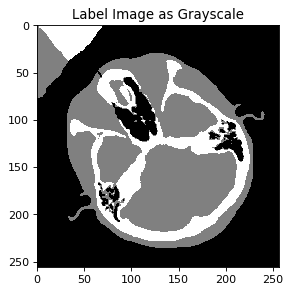

In [154]:
img1_seg = sitk.ReadImage(fdata("2th_cthead1.png"))
myshow(img1_seg, "Label Image as Grayscale")

## Grayscale to RGB Conversion:

(256, 256)
Shape: (256, 256, 3)


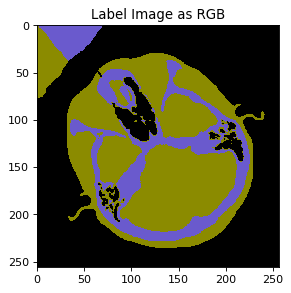

In [155]:
print(img1_seg.GetSize())
myshow(sitk.LabelToRGB(img1_seg), title="Label Image as RGB")

## Overlapping Images:

Shape: (256, 256, 3)


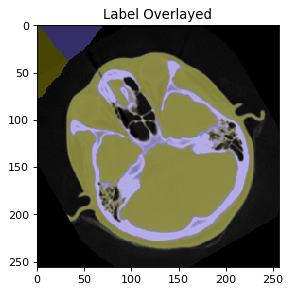

In [156]:
myshow(sitk.LabelOverlay(img1, img1_seg), title="Label Overlayed")

We can also overlay the labels as contours.

Shape: (256, 256, 3)


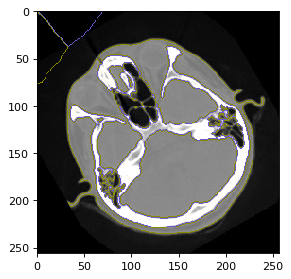

In [157]:
# We can also see the individual contour of images overlapped
myshow(sitk.LabelOverlay(img1, sitk.LabelContour(img1_seg), 1.0))

## I also tried to visualize image from site given by you but the number of channels corresponds to 9 which I don't know how to deal with

In [190]:
# nrrd(nearly raw raster data) images :
img_ss = sitk.ReadImage('DTI-Brain.nrrd') 
# image that i got from site that you shared, cannot be displayed since its contained 9 channels and 
# hence it raises Runtime error
print(sitk.GetArrayFromImage(img_ss).shape)

(85, 144, 144, 9)


In [158]:
img_T1 = sitk.ReadImage(fdata("nac-hncma-atlas2013-Slicer4Version/Data/A1_grayT1.nrrd"))
img_T2 = sitk.ReadImage(fdata("nac-hncma-atlas2013-Slicer4Version/Data/A1_grayT2.nrrd"))
img_labels = sitk.ReadImage(fdata("nac-hncma-atlas2013-Slicer4Version/Data/hncma-atlas.nrrd"))

(144, 144, 85)
Fetching nac-hncma-atlas2013-Slicer4Version/Data/A1_grayT1.nrrd
Fetching nac-hncma-atlas2013-Slicer4Version/Data/A1_grayT2.nrrd
Fetching nac-hncma-atlas2013-Slicer4Version/Data/hncma-atlas.nrrd


## Grayscale to RGB Conversion:

Shape: (256, 256, 256)
Shape: (256, 256, 256, 3)


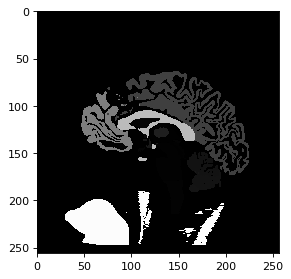

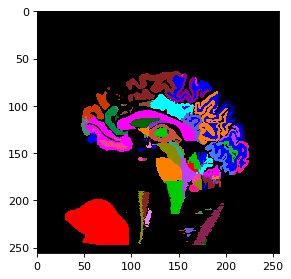

In [194]:
myshow(img_labels)
myshow(sitk.LabelToRGB(img_labels)) # grayscale to rgb 

* __Showing only 1-component of y-axis with other two components remaining intact:__

(208, 320, 288)
Shape: (208, 288)


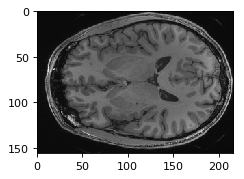

In [187]:
size = img_T1.GetSize()
print(sitk.GetArrayFromImage(img_T1).shape)
myshow(img_T1[:,size[1]//2,:])

* __Showing only 1-components of x,y & z-axis with other two components remaining intact__

Shape: (320, 896)


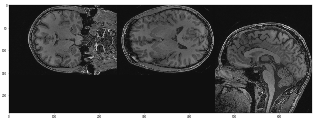

In [162]:
slices =[img_T1[size[0]//2,:,:], img_T1[:,size[1]//2,:], img_T1[:,:,size[2]//2]] 
# images corresponding to different slices
myshow(sitk.Tile(slices, [3,1]), dpi=20)

Shape: (1600, 288)


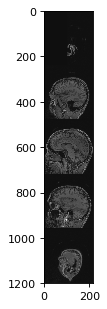

In [163]:
nslices = 5
slices = [ img_T1[:,:,s] for s in range(0, size[2], size[0]//(nslices+1))]
myshow(sitk.Tile(slices, [1,0]))

# 3D "In-Plot" Visualization | Using slicing

In [164]:
def myshow3d(img, xslices=[], yslices=[], zslices=[], title=None, margin=0.05, dpi=80):
    size = img.GetSize()
    img_xslices = [img[s,:,:] for s in xslices]
    img_yslices = [img[:,s,:] for s in yslices]
    img_zslices = [img[:,:,s] for s in zslices]
    
    maxlen = max(len(img_xslices), len(img_yslices), len(img_zslices))
    
        
    img_null = sitk.Image([0,0], img.GetPixelID(), img.GetNumberOfComponentsPerPixel())
    
    img_slices = []
    d = 0
    
    if len(img_xslices):
        img_slices += img_xslices + [img_null]*(maxlen-len(img_xslices))
        d += 1
        
    if len(img_yslices):
        img_slices += img_yslices + [img_null]*(maxlen-len(img_yslices))
        d += 1
     
    if len(img_zslices):
        img_slices += img_zslices + [img_null]*(maxlen-len(img_zslices))
        d +=1
    
    if maxlen != 0:
        if img.GetNumberOfComponentsPerPixel() == 1:
            img = sitk.Tile(img_slices, [maxlen,d])
        #TO DO check in code to get Tile Filter working with vector images
        else:
            img_comps = []
            for i in range(0,img.GetNumberOfComponentsPerPixel()):
                img_slices_c = [sitk.VectorIndexSelectionCast(s, i) for s in img_slices]
                img_comps.append(sitk.Tile(img_slices_c, [maxlen,d]))
            img = sitk.Compose(img_comps)
            
    
    myshow(img, title, margin, dpi)


Shape: (528, 2304)


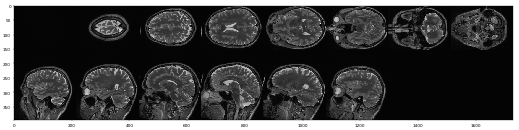

In [166]:
myshow3d(img_T2,yslices=range(50,size[1]-50,30), zslices=range(50,size[2]-50,20), dpi=30)

Shape: (512, 2816, 3)


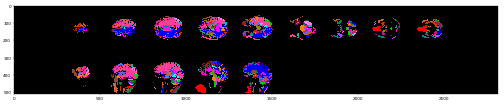

In [167]:
myshow3d(sitk.LabelToRGB(img_labels),yslices=range(50,size[1]-50,20), zslices=range(50,size[2]-50,20), dpi=30)

* __We next visualize the T1 image with an overlay of the labels.__

Shape: (208, 320, 288)


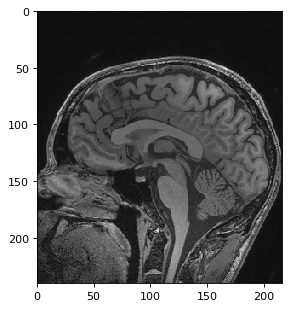

In [181]:
# To visualize the labels image in RGB with needs a image with 0-255 range
img_T1_255 = sitk.Cast(sitk.RescaleIntensity(img_T1), sitk.sitkUInt8) 
img_T2_255 = sitk.Cast(sitk.RescaleIntensity(img_T2), sitk.sitkUInt8)

myshow3d(img_T1)

# Thresholding

Shape: (208, 320, 288, 3)


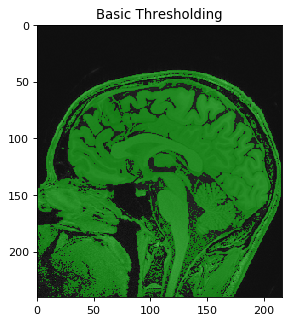

In [182]:
seg = img_T1>200 # Basic logical operations
myshow(sitk.LabelOverlay(img_T1_255, seg), "Basic Thresholding")

Shape: (208, 320, 288, 3)


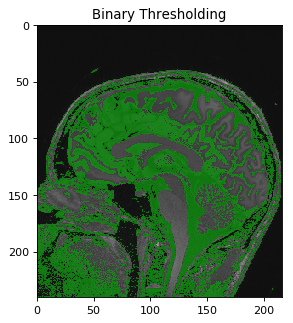

In [183]:
seg = sitk.BinaryThreshold(img_T1, lowerThreshold=100, upperThreshold=400, insideValue=1, outsideValue=0)
myshow(sitk.LabelOverlay(img_T1_255, seg), "Binary Thresholding")

# Region Growing Segmentation

Shape: (208, 320, 288, 3)


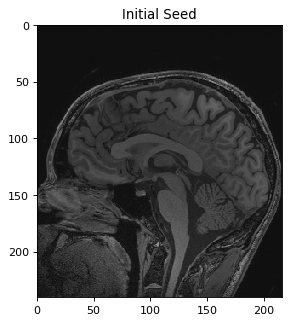

In [185]:
seed = (132,142,96)
seg = sitk.Image(img_T1.GetSize(), sitk.sitkUInt8)
seg.CopyInformation(img_T1)
seg[seed] = 1
seg = sitk.BinaryDilate(seg, 3)
myshow(sitk.LabelOverlay(img_T1_255, seg), "Initial Seed")

Shape: (208, 320, 288, 3)


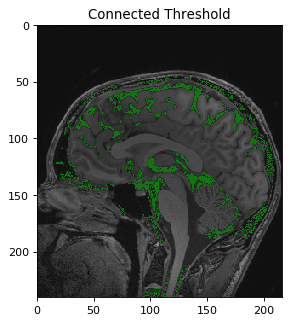

In [188]:
seg = sitk.ConnectedThreshold(img_T1, seedList=[seed], lower=100, upper=190)

myshow(sitk.LabelOverlay(img_T1_255, seg), "Connected Threshold")